In [2]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
XCr_path = os.getcwd()+'/../'
sys.path.append(XCr_path)
from XCrystal import *
t0 = time.time()

In [3]:
matplotlib.rcParams['figure.figsize'] = (12,8)
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['legend.fontsize'] = 20

## Loading XCrystal configuration

In [4]:
xcr = XCrystal(XCr_path+'/config/C400_9p8keV_Laue_Asym-sphere.yaml')
pp=xcr.configure(0,0)

Geometry file was provided
No deformation model was selected


In [5]:
xcr.cr_mask.shape

(800, 256, 300)

## Defining single realization reflection object

In [6]:

def single_realization_with_data(delta_theta,omega):
    
    xcr = XCrystal(XCr_path+'/config/C400_9p8keV_Laue_Asym-sphere.yaml',omega)
    xcr.configure(delta_theta,0)
    xcr.run3D()
    return xcr.Reflectivity, xcr.Transmission, xcr.U1_field, xcr.U2_field, xcr.u, xcr.M

In [7]:
omega0=9831

## Running beam propagation

In [8]:
U1_data = []
U2_data = []

Rs, Ts, U1_xyz, U2_xyz, up, MM = single_realization_with_data(0e-6,omega0)
U1_data.append(U1_xyz)
U2_data.append(U2_xyz)

U1_xyz = np.asarray(U1_data)
U2_xyz = np.asarray(U2_data)

Geometry file was provided
No deformation model was selected


Beam propagation progress: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s]


Photon energy (omega):  9831 ; Reflectivity:  0.013292698013909914 ; Transmission:  0.9858324004042093


## Determining relative phase between reflected and transmitted fields

In [9]:
Iy=127
ket12=np.sum(np.sum(U1_xyz[0,:,:,:]*np.conj(U2_xyz[0,:,:,:]),axis=0),axis=0)
ket21=np.sum(np.sum(U2_xyz[0,:,:,:]*np.conj(U1_xyz[0,:,:,:]),axis=0),axis=0)+1e-30
thet=np.unwrap(np.angle(-ket12/ket21))


In [10]:


Ints=np.abs(U1_xyz[0,:,:,:] + U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
Ints2=np.abs(U1_xyz[0,:,:,:]*0 + U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
Ints1=np.abs(U1_xyz[0,:,:,:] + 0*U2_xyz[0,:,:,:]*np.exp(1j*thet/2))**2
SumInts=np.abs(U1_xyz[0,:,:,:])**2 + np.abs(U2_xyz[0,:,:,:])**2

## Displaying results

(0.0, 40.0)

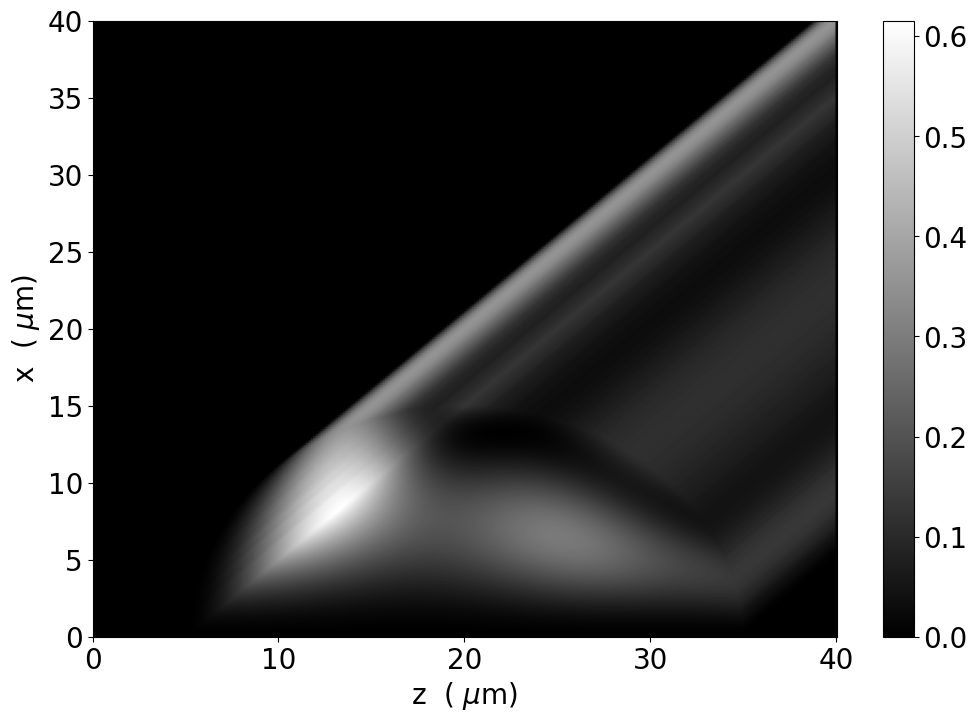

In [11]:
plt.imshow(Ints1[:,Iy,:]**1,extent=[0,xcr.M*xcr.Z/xcr.convr*1e6,-xcr.xx.max()/xcr.convr*1e6,xcr.xx.max()/xcr.convr*1e6], aspect='auto',cmap='gray')
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'z  ( $\mu$m)')
plt.colorbar()
#plt.xlim(5,6)
plt.ylim(0,40)

In [12]:
Iz=xcr.M-1

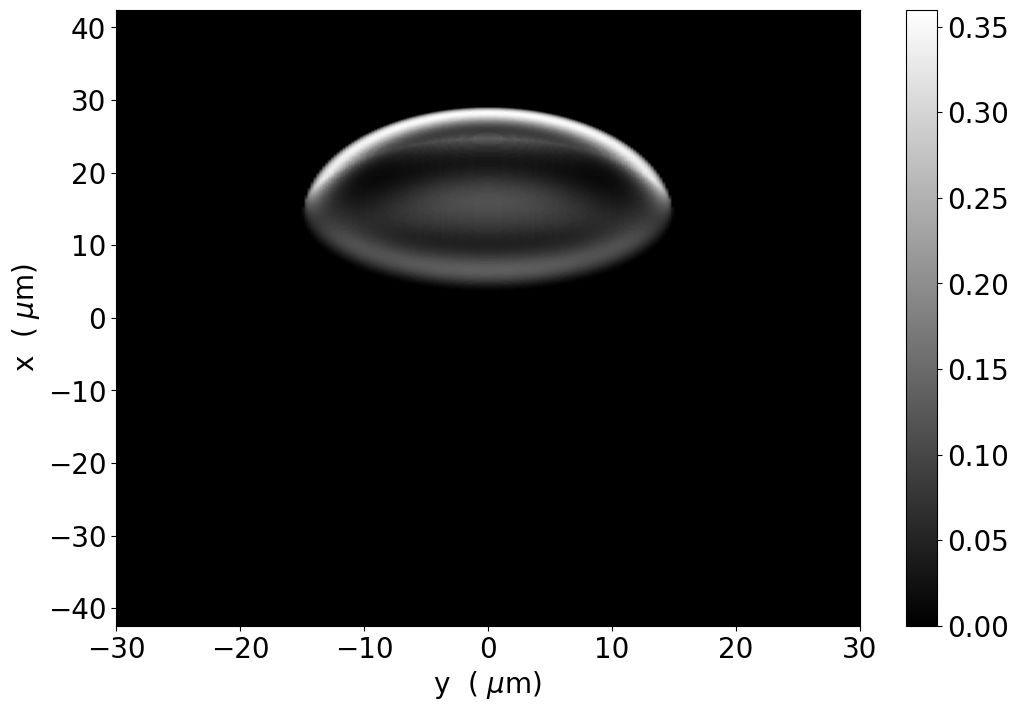

In [13]:
plt.imshow(Ints1[:,:,Iz]**1,extent=[-xcr.yy.max()/xcr.convr*1e6,xcr.yy.max()/xcr.convr*1e6,-xcr.xx.max()*xcr.cosa/xcr.convr*1e6,xcr.xx.max()*xcr.cosa/xcr.convr*1e6], aspect='auto',cmap='gray')
plt.ylabel(r'x  ( $\mu$m)')
plt.xlabel(r'y  ( $\mu$m)')
plt.colorbar()
#plt.ylim(-40,40)
#plt.xlim(-60,60)

## Propgating beam to detector position 

#### Propagation distance Lm [m]

In [14]:
Lm=2

In [15]:
L=Lm*xcr.convr

In [16]:
a= U1_xyz[0,:,:,xcr.M-1]
a=np.pad(a, ((400,400), (128,128)), 'constant', constant_values=(0.0 + 1j*0.0, 0.0 + 1j*0.0))
dxx=xcr.xx[1]-xcr.xx[0]
dyy=xcr.yy[1]-xcr.yy[0]
xxp = dxx*(np.arange(1,a.shape[0]+1) - 0.5*(a.shape[0]))
yyp = dyy*(np.arange(1,a.shape[1]+1) - 0.5*(a.shape[1]))
xxp.shape
xcr.xx.shape
yyp.shape
Yyp, Xxp = np.meshgrid(yyp,xxp) # x,y mesh/grid
dxf_out = 2*np.pi*L/(dxx*a.shape[0])
dyf_out = 2*np.pi*L/(dyy*a.shape[1])
xxp_out = dxf_out*(np.arange(1,a.shape[0]+1) - 0.5*(a.shape[0]))
yyp_out = dyf_out*(np.arange(1,a.shape[1]+1) - 0.5*(a.shape[1]))
Yyp_out, Xxp_out = np.meshgrid(yyp_out,xxp_out) # x,y mesh/grid
r_out_sq=Yyp_out**2+ Xxp_out**2 
Yyp.shape

(1600, 512)

Text(0.5, 1.0, 'Intensity at the distance 4 m form the crystal')

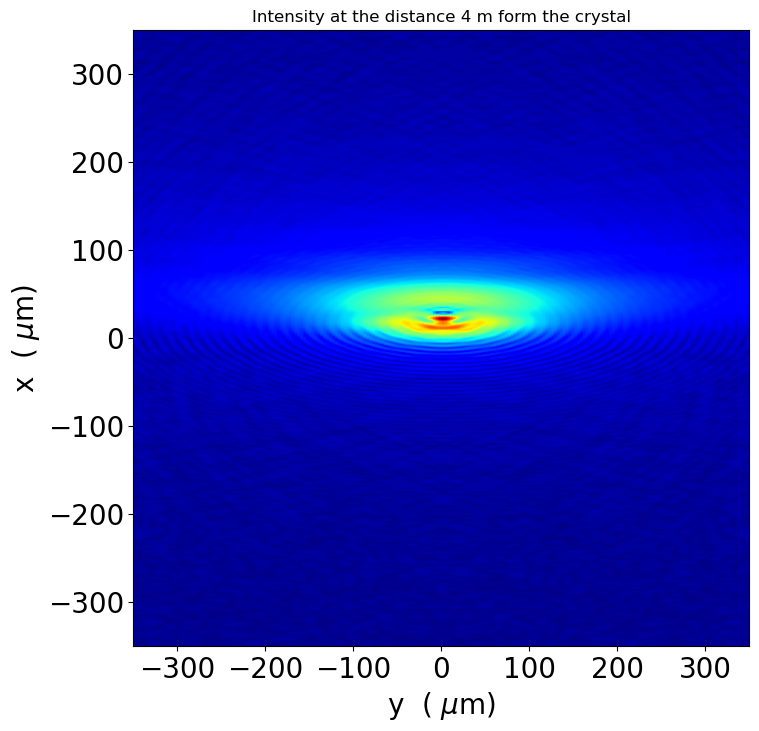

In [17]:
r_sq=Xxp**2+Yyp**2
G11 = np.fft.fftshift(np.fft.fft2(a*np.exp(1j/2*r_sq/L)), axes=(0,1))
U1_xy_out=G11*np.exp((1j/2)* r_out_sq/L)*(-1j)*dxx*dyy/(2*np.pi*L)
plt.imshow((np.abs(U1_xy_out)**0.5),extent=[xxp_out.min()/xcr.convr*1e6,xxp_out.max()/xcr.convr*1e6,yyp_out.min()/xcr.convr*1e6,yyp_out.max()/xcr.convr*1e6],cmap='jet')
plt.ylim(-350,350)
plt.xlim(-350,350)
plt.xlabel(r'y  ( $\mu$m)')
plt.ylabel(r'x  ( $\mu$m)')
plt.title('Intensity at the distance 4 m form the crystal')

In [18]:
SumInts=np.abs(U1_xyz[0,:,:,:])**2 + np.abs(U2_xyz[0,:,:,:])**2
En=np.sum(np.sum(Ints,axis=0),axis=0) 
EnSumInt=np.sum(np.sum(SumInts,axis=0),axis=0) 

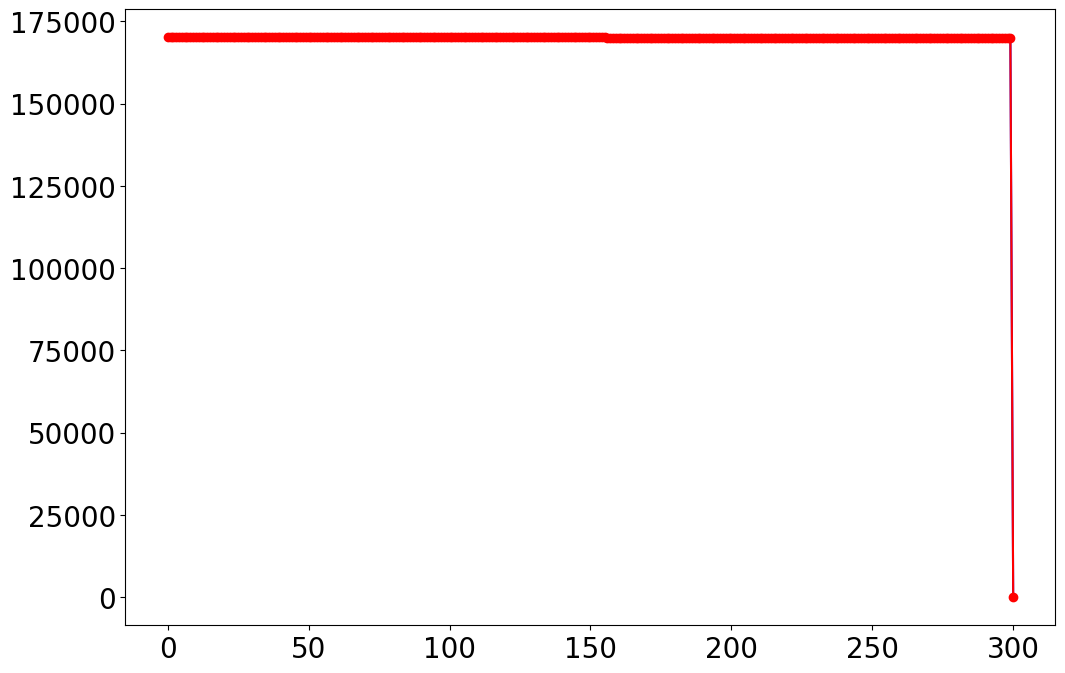

In [19]:
plt.plot(En,'b.-')
plt.plot((EnSumInt),'ro-')
#plt.ylim(80000,100000)
plt.show()

In [20]:
t1 = time.time()
t1-t0

85.21295237541199

In [21]:
xcr.cr_mask.shape

(800, 256, 300)

In [22]:
231/95

2.431578947368421